# Density Functional Theory (DFT) for an Atom

DFT is a quantum mechanical method used to investigate the electronic structure of many-body systems, particularly atoms, molecules, and solids. It simplifies the complex interactions between electrons by using functionals of the electron density rather than wavefunctions. 

In this exercise we will solve a multielectron atom in local density approximation (LDA). LDA is the simplest approximation in DFT, where the exchange-correlation energy is approximated by that of a homogeneous electron gas with the same local density.

We will test it on He and oxygen by computing the total energy and charge density.

We will plot charge density and compute the total energy, which will be compared to the reference data at NIST database:
https://www.nist.gov/pml/atomic-reference-data-electronic-structure-calculations/atomic-reference-data-electronic-7




We want to solve the Schrödinger equation for an atom with nucleus charge Z. We will approximate electron-electron interaction with an effective potential, which is computed by so-called "local density approximation" (LDA). In this theory, the classical (Hartree) potential is treated exactly, while the rest of the interaction is "approximated" by so called *local exchange-correlation functional*. We will not go into details of this functional, we will just use it here.



The Schrödinger equation we are solving is
\begin{align}
(-\frac{\hbar^2}{2m}\nabla^2-\frac{Z e^2}{4\pi\varepsilon_0 r} + V_H(r) + V_{xc}(r))\psi(\vec{r})=\varepsilon \psi(\vec{r})
\end{align}

The first two terms are appearing in Hydrogen problem, and we already coded them. The Hartree is the electrostatic potential, and the exchange-correlation potential has an approximate form, which depends only the charge density of the system. We will use the module `excor.py`, where the function $V_{xc}(\rho)$ is tabulated. We will use it as $V_{xc}(r) = V_{xc}(\rho(r))$, corresponding to the local density approximation.

Using atomic units, the equation is:
\begin{align}
\left(-\nabla^2-\frac{2Z}{r}+V_H(r)+V_{xc}(r)-\varepsilon\right)\psi(r)=0
\end{align}
and when spherical symmetry of an atom is taken into account:
\begin{align}
u''(r)-
\left(\frac{l(l+1)}{r^2}-\frac{2Z}{r}+V_H(r)+V_{xc}(r)-\varepsilon\right)u(r)=0
\end{align}


First we take the code from the Hydrogen project and repeat.

In [15]:
from scipy import integrate
from scipy import optimize
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from numba import jit

In [16]:
@jit(nopython=True)
def Numerov(f, x0, dx, dh):
    """ Given precumputed function f(x) solved the differential equation
        x''(t) = f(t) x(t)
        input: x0 = x(t=0), and dx = dx/dt(t=0)
    """
    x = np.zeros(len(f))
    x[0] = x0
    x[1] = x0 + dh*dx
    h2 = dh**2
    h12 = h2/12.
    w0 = x0*(1-h12*f[0])
    w1 = x[1]*(1-h12*f[1])
    xi = x[1]
    fi = f[1]
    for i in range(2,len(f)):
        w2 = 2*w1-w0 + h2*fi*xi
        fi = f[i]
        xi = w2/(1-h12*fi)
        x[i]=xi
        (w0,w1) = (w1,w2)
    return x

@jit(nopython=True)
def fShrod(En,l,R):
    return l*(l+1.)/R**2 - 2./R - En

def ComputeSchrod(En, R, l):
    f = fShrod(En,l,R[::-1])
    ur = Numerov(f, 0.0, -1e-7, -R[1]+R[0])[::-1]
    norm = integrate.simpson(ur**2, x=R)
    return ur/np.sqrt(np.abs(norm))
    
def Shoot(En, R, l):
    ur = ComputeSchrod(En, R, l)
    ur = ur/R**l  # expecting urn \propto R
    #f0,f1 = ur[0],ur[1]
    #f_at_0 = f0 + (f1-f0)*(0-R[0])/(R[1]-R[0]) # extrapolation to zero
    #return f_at_0
    #poly = np.polyfit(R[:4], ur[:4], deg=3)
    #return np.polyval(poly, 0.0)
    poly = Polynomial.fit(R[:4], ur[:4], deg=3)
    return poly(0.0)        

def FindBoundStates(R, l, nmax, Esearch):
    n=0
    Ebnd=[]
    u0 = Shoot(Esearch[0],R,l)
    for i in range(1,len(Esearch)):
        u1 = Shoot(Esearch[i],R,l)
        if u0*u1 < 0:
            #print 'Sign change at', Esearch[i-1], Esearch[i]
            Ebound = optimize.brentq(Shoot,Esearch[i-1],Esearch[i],xtol=1e-15,args=(R,l))
            Ebnd.append( (l,Ebound) )
            if len(Ebnd)>nmax: break
            n += 1
            print('Found bound state at E=%14.9f' % Ebound)
        u0 = u1
    return Ebnd 

def cmpKey(x):
    return x[1]*1000 + x[0]  # energy has large wait, but degenerate energy states are sorted by l

def ChargeDensity(Bnd,R,Z):
    rho = np.zeros(len(R))
    N=0.
    for (l,En) in Bnd:
        ur = ComputeSchrod(En, R, l)
        dN = 2*(2*l+1)
        if N+dN <= Z:
            ferm = 1.
        else:
            ferm = (Z-N)/float(dN)
        drho = ur**2 * ferm * dN/(4*np.pi*R**2)
        rho += drho
        N += dN
        print('adding state', (l,En), 'with fermi=', ferm)
        if  N>=Z: break
    return rho

Found bound state at E=  -0.999999943
Found bound state at E=  -0.249999990
Found bound state at E=  -0.111111108
Found bound state at E=  -0.062499999
Found bound state at E=  -0.039999942
Found bound state at E=  -0.249999998
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999957
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999977
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999992
adding state (0, -0.9999999428189246) with fermi= 1.0
adding state (0, -0.2499999899816246) with fermi= 1.0
adding state (1, -0.24999999797145775) with fermi= 1.0
adding state (0, -0.11111110835536915) with fermi= 1.0
adding state (1, -0.11111111057681711) with fermi= 1.0
adding state (2, -0.1111111111469023) with fermi= 1.0


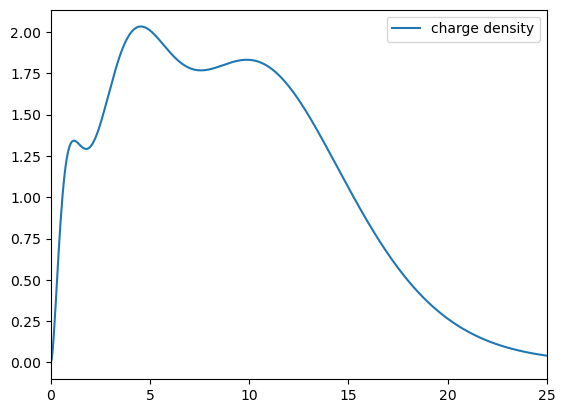

In [17]:
%matplotlib inline

Esearch = -1.2/np.arange(1,20,0.2)**2
R = np.linspace(1e-6,100,2000)

Z=28
nmax = 5
Bnd=[]
for l in range(nmax-1):
    Bnd += FindBoundStates(R,l,nmax-l,Esearch)
Bnd = sorted(Bnd, key=cmpKey)

rho = ChargeDensity(Bnd,R,Z)
        
plt.plot(R, rho*(4*np.pi*R**2), label='charge density')
plt.xlim([0,25])
plt.legend(loc='best')
plt.show()

## Hartree term

The Hartree term is treated exactly in this approximation. 

It describes the electrostatic
interaction of one electron with the cloud of all electrons (including the electron itself).

This is classical electrostatic term. Namely, any electron feels not only the nucleus with Coulomb attraction $-2Z/r$, but also the charge of all (other) electrons $\rho(\vec{r}')$ through the same Coulomb force, but it is repulsive, hence we should have $$-2Z/r \rightarrow -2Z/r + \int d\vec{r}' \frac{2\rho(\vec{r}')}{|\vec{r}-\vec{r}'|}$$


Mathematically, this term comes from the mean-field approximation (lowest order) of the Coulomb repulsion between electrons:

\begin{align}
&&   \frac{1}{2}\int d\vec{r} d\vec{r}' \psi^\dagger (\vec{r})\psi^\dagger (\vec{r}')
   v_c(\vec{r}-\vec{r}') \psi(\vec{r}')\psi(\vec{r}) \rightarrow\\
&&   \int d\vec{r} \psi^\dagger(\vec{r}) \psi(\vec{r}) \int d\vec{r}'
   \langle\psi^\dagger(\vec{r}') \psi(\vec{r}')\rangle v_c(\vec{r}-\vec{r}') \equiv
   \int d\vec{r} \psi^\dagger(\vec{r}) V_{H}(\vec{r}) \psi(\vec{r})\nonumber
 \end{align}
 with

 \begin{equation}
 V_H(\vec{r}) = 2 \int d\vec{r}' \frac{\rho(\vec{r}')}{|\vec{r}-\vec{r}'|}
 \end{equation}

where $2$ is due to Rydberg units since $v_c = 2/r$.


For any atom, the electron density is
spherically symmetric and hence $V_{H}$ depends only on radial
distance. (In solids, the hartree potential should be expanded in
spheric harmonics to sufficiently high $l$, maybe $l=6$).


### Step 1: Using $\rho(r)$, compute the Hartree potential.

This is usually achieved by solving the Poisson equation. From
classical electrostatic we know
\begin{align}
  \nabla^2 V_{H}(\vec{r}) = -8\pi \rho(\vec{r})
\end{align}
If we express $\nabla$ in spherical coordinates, we get:
\begin{equation}
\frac{1}{r^2}\frac{d}{dr}(r^2 \frac{d V_H}{dr})= -8\pi\rho(r)  
\end{equation}
which simplifies to
\begin{equation}
  U^{''}(r) = -8\pi r \rho(r)
\end{equation}
where $V_{H}(r) = U(r)/r$.

This second order differential equation has the following boundary
conditions $U(0)=0$ and $U(\infty)=2 Z$.

The two point boundary problem does not require shooting because we
know solution to the homogenous differential equation
$U^{''}(r)=0$. The Hartree potential can be obtained from any
particular solution by
\begin{equation}
  U(r) = U_p(r) + \alpha r
\end{equation}
where $\alpha = \lim_{r\rightarrow\infty}(2 Z-U_{p}(r))/r$.


In [18]:
def FuncForHartree(y,r,rhoSpline):
    """ y = [U,U']
        dy/dr = [U', -8*pi*r*rho(r)]
    """
    return [y[1], -8*np.pi*r*rhoSpline(r)]

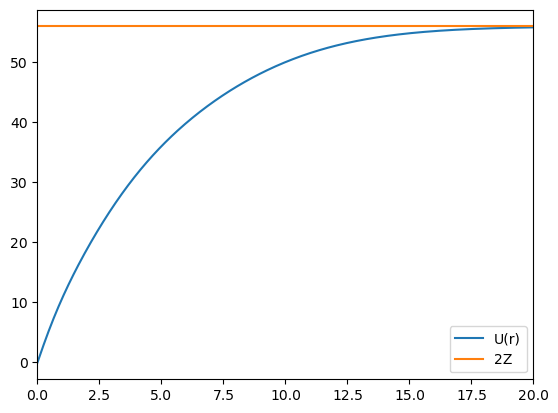

In [19]:
from scipy import interpolate

rhoSpline = interpolate.UnivariateSpline(R, rho,s=0)

U0 = integrate.odeint(FuncForHartree, [0.0,0.5], R, args=(rhoSpline,))[:,0]
alpha = (2*Z - U0[-1])/R[-1]
U0 += alpha * R

plt.plot(R, U0,label='U(r)')
plt.plot(R, np.ones(len(R))*2*Z, label='2Z')
plt.xlim([0,20])
plt.legend(loc='best')
plt.show()

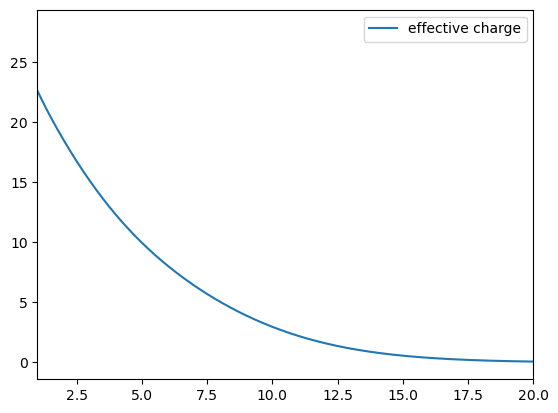

In [20]:
plt.plot(R, Z-U0/2,label='effective charge')
plt.xlim([1,20])
plt.legend(loc='best')
plt.show()

## Numerov again

Poisson equation does not have the first order derivative, hence it can also be more efficiently solved by the Numerov algorithm.

We have Poisson equation, which has the form
\begin{equation}
x^{''}(t)= u(t)
\end{equation}
and the Numerov algorithm, as appropriate for the Poisson equation, is

\begin{align}
  x(h)+x(-h) = 2x(0)+h^2 u(0)+\frac{2}{4!}h^4 x^{(4)}(0)+O(h^6)
\end{align}

and the approximation for the forth order derivative is
\begin{equation}
  x^{(4)}\sim \frac{u_{i+1}-2 u_i+u_{i-1}}{h^2}
\end{equation}

Inserting the fourth order derivative into the above recursive equation (forth equation in his chapter), we
get

\begin{equation}
  x_{i+1}-2 x_i+x_{i-1}=h^2 u_i +\frac{h^2}{12}(u_{i+1}-2 u_i+u_{i-1})
\end{equation}

If we switch to a new variable $w_i=x_i-\frac{h^2}{12}u_i$
we are left with the following
equation

\begin{equation}
  w_{i+1} -2 w_i + w_{i-1} = h^2 u_i+O(h^6)
\end{equation}

The variable $x$ needs to be recomputed at each step with
$x_i=(w_i+\frac{h^2}{12}u_i)$.


In [21]:
@jit(nopython=True)
def NumerovUP(U, x0, dx, dh):
    x = np.zeros(len(U))
    x[0] = x0
    x[1] = dx*dh + x0
    h2 = dh*dh
    h12 = h2/12
    w0 = x[0]-h12*U[0]
    w1 = x[1]-h12*U[1]
    Ui = U[1]
    for i in range(2,len(U)):
        w2 = 2*w1 - w0 + h2*Ui
        Ui = U[i]
        xi = w2 + h12*Ui
        x[i] = xi
        w0, w1 = w1, w2
    return x

In [22]:
U2 = NumerovUP(-8*np.pi*R*rho, 0.0, 0.5, R[1]-R[0])
alpha2 = (2*Z-U2[-1])/R[-1]
U2 += alpha2 * R

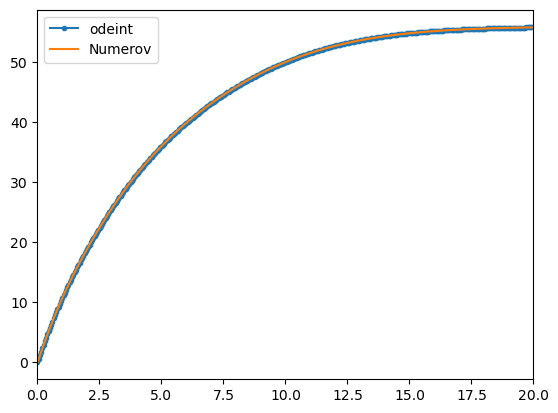

In [23]:
plt.plot(R,U0,'.-',label='odeint')
plt.plot(R,U2,'-',label='Numerov')
plt.xlim([0,20])
plt.legend(loc='best')
plt.show()

### Step1 routine HartreeU  
For generic density the following routine will work:

In [24]:
def HartreeU(R, rho, Zatom):
    """Given input charge density it returns Hartree potential in the form VH(r)*r
    """
    U2 = NumerovUP(-8*np.pi*R*rho, 0.0, 0.5, R[1]-R[0])
    alpha2 = (2*Zatom-U2[-1])/R[-1]
    U2 += alpha2 * R
    return U2

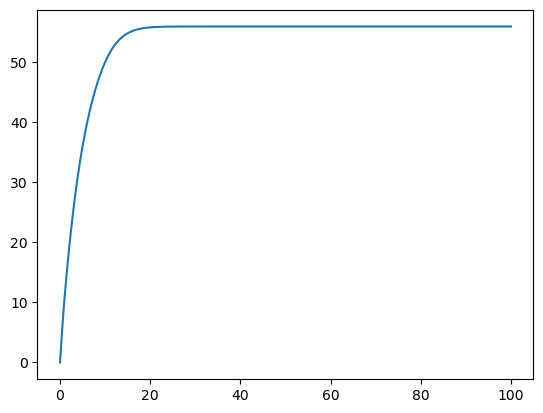

In [25]:
U2 = HartreeU(R,rho,Z)
plt.plot(R,U2)
plt.show()

### Step 2 : Compute the exchange correlation potential.
   
Note that $V_{xc}(r)=V_{xc}(\rho(r))$ is unquely determined by the electron charge density $\rho(r)$. If we know $\rho$, we can instantly compute $V_{xc}$ by the module provided parametrized function.
   

The module `excor.py` is from http://www.physics.rutgers.edu/~haule/509/src_prog/python/homework5

Instantiate the ExchangeCorrelation object by

`exc = ExchangeCorrelation()`

and used it, for example, by

`exc.Vx(rs(rho[i]))+exc.Vc(rs(rho[i]))`

where $r_s = ({4\pi\rho/3})^{-1/3}$.

Be careful: The energy unit in "excor.py" is Hartree and not
Rydergs. Hence, you need to multiply energy or potential by 2.



In [26]:
from excor import ExchangeCorrelation
exc = ExchangeCorrelation()

@jit(nopython=True)
def rs(rho):
    "1/rho = 4*pi*rs^3/3 => rs = (3/(4*pi*rho))**(1/3.)"
    if rho < 1e-100: return 1e100
    return pow(3/(4*np.pi*rho),1/3.)

### Step 3: Find bound states using Hartree and XC potential.

Add the Hartree potential and the exchange-correlation potential to the Schrödinger equation and find
  bound states of the atom.

The Schrödinger equation is

 \begin{equation}
   u^{''}(r) = \left(\frac{l(l+1)}{r^2}-\frac{2 Z}{r} + V_{H}(r)+V_{XC}(r)-\varepsilon\right)u(r).
 \end{equation}

or

  \begin{equation}
   u^{''}(r) = \left(\frac{l(l+1)}{r^2}+\frac{U_H - 2 Z +r V_{XC}}{r}-\varepsilon\right)u(r).
 \end{equation}

 
 We will use notation:
 $$U_{KS}=U_H - 2 Z +r V_{XC}$$
 so that

   \begin{equation}
   u^{''}(r) = \left(\frac{l(l+1)}{r^2}+\frac{U_{KS}}{r}-\varepsilon\right)u(r).
 \end{equation}


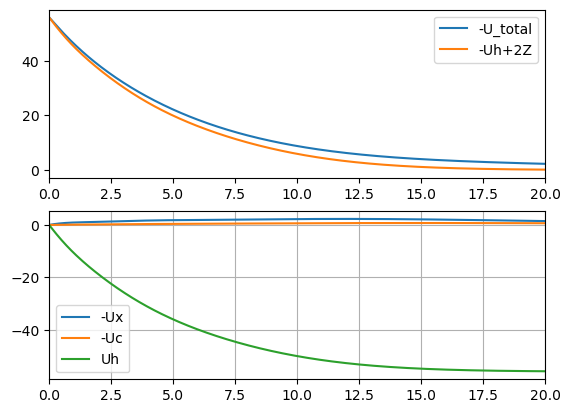

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming exc, rs, rho, R, U2, and Z are defined earlier in the code

Vxc = np.array([2*exc.Vc(rs(rh)) + 2*exc.Vx(rs(rh)) for rh in rho])    # factor of 2 due to change of units from Hartree to Rydbers
Vx = np.array([2*exc.Vx(rs(rh)) for rh in rho])  
Vc = np.array([2*exc.Vc(rs(rh)) for rh in rho])
Uks = U2 - 2*Z + Vxc*R

fig,(ax1, ax2) = plt.subplots(2, 1)
ax1.plot(R, -Uks, label='-U_total');
ax1.plot(R, -U2+2*Z, label='-Uh+2Z')
#ax1.plot(R, -U2+2*Z, label='-Uh+2Z')
ax2.plot(R,-Vx*R,label='-Ux')
ax2.plot(R,-Vc*R,label='-Uc')
ax2.plot(R,-U2,label='Uh')
ax2.legend(loc='best')
ax1.legend(loc='best')
ax2.grid()
ax1.set_xlim([0,20])
ax2.set_xlim([0,20])
plt.show()

The effective potential $U_{KS} = r(V_H+V_{xc}-2 Z/r)$ has the following features:
* at small $r$ it is just bare nucleus potential $U_{KS}=-2 Z$ because $V_{KS}=-2 Z/r$
* at large $r$ the screening of nuclear charge is perfect, and $U_{KS}=0$ exponentially fast beyond the charge cloud, hence $U_{KS}\approx 2(\rho_{inside}-Z)$ vanishes exponentially.

In [28]:
@jit(nopython=True)
def fShrod(En,l,R, Uks):
    return (l*(l+1.)/R +Uks)/R - En

def ComputeSchrod(En, R, l, Uks):
    #f = fShrod(En,l,R[::-1],Uks[::-1])
    #ur = Numerov(f, 0.0, -1e-10, R[0]-R[1])[::-1]
    f = fShrod(En,l,R, Uks)
    ur = Numerov(f[::-1], 0.0, -1e-10, R[0]-R[1])[::-1]
    norm = integrate.simpson(ur**2, x=R)
    return ur/np.sqrt(np.abs(norm))

def Shoot(En, R, l, Uks):
    ur = ComputeSchrod(En, R, l,Uks)
    ur *= 1/R**l  # expecting urn \propto R
    #f0,f1 = ur[0],ur[1]
    #f_at_0 = f0 + (f1-f0)*(0-R[0])/(R[1]-R[0]) # extrapolation to zero
    #return f_at_0
    poly = Polynomial.fit(R[:4], ur[:4], deg=3)
    #poly = Polynomial.fit(R[:2], ur[:2], deg=1)
    return poly(0.0)

In [36]:
def FindBoundStates(R, l, nmax, Esearch, Uks, silent=False):
    n=0
    Ebnd=[]
    u0 = Shoot(Esearch[0],R,l,Uks)
    for i in range(1,len(Esearch)):
        u1 = Shoot(Esearch[i],R,l,Uks)
        if u0*u1 < 0:
            Ebound = optimize.brentq(Shoot,Esearch[i-1],Esearch[i],xtol=1e-15,args=(R,l,Uks))
            Ebnd.append( (l,Ebound) )
            if len(Ebnd)>nmax: break
            n += 1
            if not silent:
                print(f"Found bound state at E={Ebound/2:14.9f}H l={l:2d}")
        u0 = u1
    return Ebnd 

In [30]:
## From before we are using
# R = linspace(1e-6,100,2000)
# Esearch = -1.2/arange(1,20,0.2)**2
nmax=5

Bnd=[]
for l in range(nmax-1):
    Bnd += FindBoundStates(R,l,nmax-l,Esearch,Uks)
    
Bnd = sorted(Bnd, key=cmpKey)

Found bound state at E=  -0.301181700H l= 0
Found bound state at E=  -0.114301424H l= 0
Found bound state at E=  -0.034082204H l= 0
Found bound state at E=  -0.003612354H l= 0
Found bound state at E=  -0.313798778H l= 1
Found bound state at E=  -0.118616033H l= 1
Found bound state at E=  -0.034746947H l= 1
Found bound state at E=  -0.003345161H l= 1
Found bound state at E=  -0.300009838H l= 2
Found bound state at E=  -0.108653489H l= 2
Found bound state at E=  -0.028845107H l= 2
Found bound state at E=  -0.279116709H l= 3
Found bound state at E=  -0.093722034H l= 3


### Step 4: Compute the new electron density
by filling the lowest $Z$ eigenstates.

In [39]:
# This is modified from Hydrogen
def ChargeDensity(bst,R,Zatom,Uks,silent=False):
    rho = np.zeros(len(R))
    N=0.
    Ebs=0.  # sum of all eigenvalues of KS equation.
    for (l,En) in bst:
        ur = ComputeSchrod(En, R, l, Uks)
        dN = 2*(2*l+1)
        if N+dN <= Zatom:
            ferm = 1.
        else:
            ferm = (Zatom-N)/float(dN)
        drho = ur**2 * ferm * dN/(4*np.pi*R**2)
        rho += drho
        N += dN
        Ebs += En * dN * ferm
        if not silent:
            print('adding state', (l,En/2), 'H with fermi=', ferm)
        if  N>=Zatom: break
    return (rho,Ebs)

In [40]:
Z=28
rho_new, Ebs = ChargeDensity(Bnd,R,Z,Uks)

adding state (0, -18.75823237530761) H with fermi= 1.0
adding state (0, -0.8713524151657164) H with fermi= 1.0
adding state (1, -0.3383710480910696) H with fermi= 1.0
adding state (0, 0.014517541877808121) H with fermi= 1.0


### Step 5: Admix the new and the old density 
(50\% of the old and 50\%  of the new should work) and use the resulting density to compute the  new Hartree and exchange-correlation potential.

### Iterate Steps 1 to Step 5 until self-consistency is achieved.

### Evaluate the total energy

Once we see that the code converges, we can insert a new step
between *Step 4* and *Step 5* to compute the total energy of
the system. The total energy can be obtained by
\begin{align}
E^{LDA}_{total} =& \sum_{i\in occupied}\int d\vec{r}
\psi_i^*(\vec{r})[-\nabla^2]\psi_i(\vec{r}) +\nonumber\\
 &+ \int d\vec{r} \rho(\vec{r}) [V_{nucleus}(\vec{r})+\epsilon_H(\vec{r}) +
   \epsilon_{XC}(\vec{r})]\nonumber\\
 =& \sum_{i\in occupied}\int d\vec{r}
\psi_i^*(\vec{r})[-\nabla^2+V_{nucleus}+V_H+V_{XC}]\psi_i(\vec{r})
 \nonumber\\
 &+ \int d\vec{r} \rho(\vec{r}) [\epsilon_H(\vec{r})-V_H(\vec{r}) +
   \epsilon_{XC}(\vec{r})-V_{XC}(\vec{r})]\nonumber\\
 =& \sum_{i\in occupied}\epsilon_i + \int d\vec{r} \rho(\vec{r}) [\epsilon_H(\vec{r})-V_H(\vec{r}) +
   \epsilon_{XC}(\vec{r})-V_{XC}(\vec{r})]\nonumber\\
 =& \sum_{i\in occupied}\epsilon_i + \int d\vec{r} \rho(\vec{r}) [-\epsilon_H(\vec{r}) +
   \epsilon_{XC}(\vec{r})-V_{XC}(\vec{r})]
\end{align}
Here we used
\begin{align}
&& E_H[\rho] \equiv \int d\vec{r}\; \rho(\vec{r})\; \epsilon_H[\rho(\vec{r})]\\
&& E_{xc}[\rho] \equiv \int d\vec{r}\; \rho(\vec{r})\; \epsilon_{xc}[\rho(\vec{r})]\\
&& V_H[\rho]\equiv \frac{\delta E_H[\rho]}{\delta \rho(\vec{r})}\\
&& V_{xc}[\rho]\equiv \frac{\delta E_{xc}[\rho]}{\delta \rho(\vec{r})}.
\end{align}

Here the Hartree energy is the classical electrostatic potential energy, i.e.,
\begin{equation}
E_H = \int d\vec{r} d\vec{r}' \frac{\rho(\vec{r})\rho(\vec{r}')}{|\vec{r}-\vec{r}'|},
\end{equation}
hence
\begin{align}
\epsilon_H(\vec{r}) = \frac{1}{2} V_H(\vec{r}) = \int d\vec{r}' \frac{\rho(\vec{r}')}{|\vec{r}-\vec{r}'|}\\
\end{align}
and we also know
\begin{align}
V_H(\vec{r})= \frac{U_H(\vec{r})}{r}
\end{align}
Hence
$$\epsilon_H(\vec{r})=\frac{1}{2}\frac{U_H}{r}$$


The exchange-correlation energy can be obtained by a call to the
 method of ${ExchangeCorrelation}$ object.


For oxygen, the total energy in this implementation is : -74.4730769 Hartree, while NIST shows -74.473077 Hartree. This is in excellent agreement in all digits provided by NIST. 

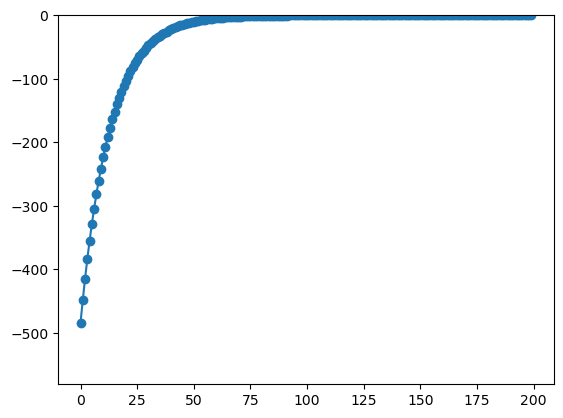

In [33]:
import numpy as np
import matplotlib.pyplot as plt

Zatom=22
E0=-1.0*Zatom**2
Eshift=0.1 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -np.logspace(-4,np.log10(-E0+Eshift),200)[::-1] + Eshift
#Esearch = -np.logspace(-4,np.log10(-E0+Eshift),500)[::-1] + Eshift
plt.plot(Esearch,'o-')
plt.ylim([-1.2*Zatom**2,1])
plt.show()

#plt.ylim([-0.2,0.])

We will first demonstrate algorithm on oxygen $Z=8$ and then on Potassium ($Z=19$), which has first nontrivial "aufbau" principle in which $4s$ orbital gets filled before $3d$.

Iteration 0 Etot[Ry]= -12.254224531553518 Etot[Hartre]= -6.127112265776759 Diff= 12.254224531553518
Iteration 1 Etot[Ry]= -5.107747003026387 Etot[Hartre]= -2.5538735015131935 Diff= 7.146477528527131
Iteration 2 Etot[Ry]= -5.52637515978268 Etot[Hartre]= -2.76318757989134 Diff= 0.4186281567562933
Iteration 3 Etot[Ry]= -5.6329609035394235 Etot[Hartre]= -2.8164804517697117 Diff= 0.10658574375674323
Iteration 4 Etot[Ry]= -5.66065475591369 Etot[Hartre]= -2.830327377956845 Diff= 0.02769385237426647
Iteration 5 Etot[Ry]= -5.667773802585916 Etot[Hartre]= -2.833886901292958 Diff= 0.007119046672226403
Iteration 6 Etot[Ry]= -5.669464996272857 Etot[Hartre]= -2.8347324981364284 Diff= 0.0016911936869403732
Iteration 7 Etot[Ry]= -5.669781251238888 Etot[Hartre]= -2.834890625619444 Diff= 0.00031625496603115977
Iteration 8 Etot[Ry]= -5.669787979217713 Etot[Hartre]= -2.8348939896088563 Diff= 6.727978824727643e-06
Iteration 9 Etot[Ry]= -5.6697477184441905 Etot[Hartre]= -2.8348738592220952 Diff= 4.026077352

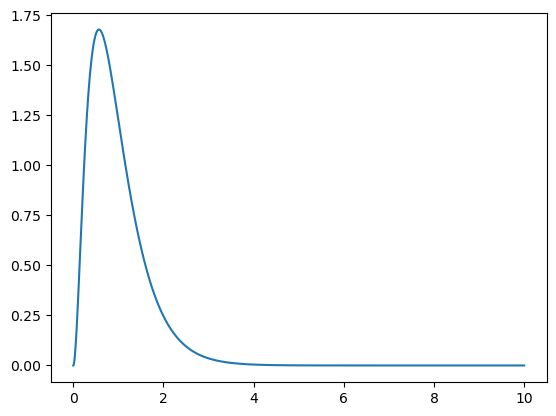

In [46]:
R = np.linspace(1e-8,10,2**14+1)
Zatom = 2 # 30 #29 works 20  # 19
mixr = 0.5

E0=-1.2*Zatom**2
Eshift=0.1 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -np.logspace(-4,np.log10(-E0+Eshift),500)[::-1] + Eshift
nmax = 4 #3

exc = ExchangeCorrelation()
Uks = -2*Zatom*np.ones(len(R))  # here I changed from -2 to -2*Zatom
Eold = 0
Etol = 1e-7

for itt in range(100):
    Bnd=[]
    for l in range(nmax-1):
        Bnd += FindBoundStates(R,l,nmax-l,Esearch,Uks, silent=True)
    
    Bnd = sorted(Bnd, key=cmpKey)
    rho_new, Ebs = ChargeDensity(Bnd,R,Zatom,Uks, silent=True)
    
    if itt==0:
        rho = rho_new
    else:
        rho = rho_new * mixr + (1-mixr)*rho_old
    rho_old = np.copy(rho)
    
    U2 = HartreeU(R, rho, Zatom)

    Vxc = [2*exc.Vc(rs(rh)) + 2*exc.Vx(rs(rh)) for rh in rho]   
    
    Uks = U2 - 2*Zatom + Vxc*R

    # Total energy
    ExcVxc = [2*exc.EcVc(rs(rh)) + 2*exc.ExVx(rs(rh)) for rh in rho]  # eps_xc(rho)-V_xc(rho)
    pot = (ExcVxc*R - 0.5*U2)*R*rho*4*np.pi                              # (eps_xc-V_xc-0.5 U_H/R)*rho * d^3r
    epot = integrate.simpson(pot, x=R)
    Etot = epot + Ebs
    
    # print('Total density has weight', integrate.simpson(rho*(4*np.pi*R**2),x=R))
    #print('Total Energy=', Etot/2.)
    
    print('Iteration', itt, 'Etot[Ry]=', Etot, 'Etot[Hartre]=', Etot/2, 'Diff=', np.abs(Etot-Eold))

    
    if  itt>0 and np.abs(Etot-Eold)< Etol: break
    Eold = Etot
    
    #plt.plot(R, U2, label='U-hartree')
    #plt.plot(R, Vxc, label='Vxc')
    #plt.plot(R, Uks, label='Uks')
    #plt.show()
    
plt.plot(R,rho*(4*np.pi*R**2))
#plt.xlim([0,5])
plt.show()

# Homework

1) Compute charge density and total energy for oxygen atom, as we have done in class. Check that your code agrees with NIST values.

2) Get the code working for potassium (Z=19) and check that LDA respects aufbau principle of the periodic table.

3) How far (in periodic table) can you push the algorithm? What part needs improvements to extend the algorithm to higher Z? Currently Z=21 is breaking down due to some instability. Check Z=29 first and then check what you need to change to get Z=22-28 working.
